# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

The data set is about 0.055 MB with 1339 entries and 7 features. The data does contain categorical data such as smoker, region, and sex. The best thing is that the data has no missing value. One fundamental statistic I learned right away about this dataset is that the insurance company charges differently based on one's age, sex, number of children, and whether or not one is smoking. Another thing is that the price charging range is in a considerable gap.

In [1]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "assignment_1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  """Save the selected figure into disc under an image extention and resolution

  Parameters
  ----------
  fig_id : figure handle
    The id number of the figure
  tight_layout : boolean (True or False)
    Specifies whenther the layout should be tight or not
  fig_extension: string
    Under what extension should the file be saved ("png" or "jpg")
  resolution: int
    the quality of the figure (ie. 100,200,300)

  Returns
  -------
  void
    Does not return any value
  """

  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import pandas as pd

# To help you get started, a load function is provided below. 
# You will need to fill in the code under #TODO to make it work.
def load_medical_cost_data():
  # The column names are adopted from the dataset page on Kaggle   
  medical_cost = pd.read_csv('./insurance.csv')
  return medical_cost

medical_cost = load_medical_cost_data()
# Display the first n rows of the data. (n=5 by default, we will use 10 rows)
medical_cost.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING 

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [3]:
# Check to see if there's any missing value in the data with .isnull()
sample_incomplete_rows = medical_cost[medical_cost.isnull().any(axis=1)].head()
sample_incomplete_rows
# NO Missing value 

,age,sex,bmi,children,smoker,region,charges


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd45486fd50>,
      dtype=object)

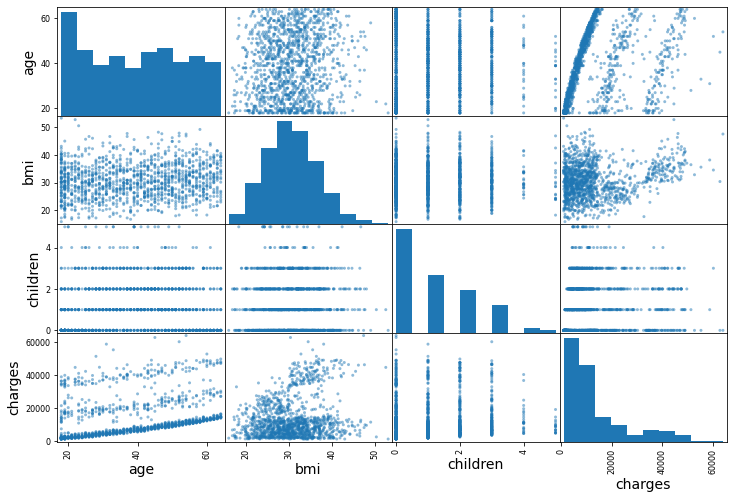

In [4]:
from pandas.plotting import scatter_matrix

corr_matrix = medical_cost.corr()
corr_matrix["charges"].sort_values(ascending=False)
attributes = ["age", "bmi", "children", "charges"]
scatter_matrix(medical_cost[attributes], figsize=(12, 8))

In [5]:
medical_cost["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [6]:
medical_cost["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [7]:
medical_cost["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [8]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer


# Your code goes here for this section.
medical_cost_features = medical_cost.copy()
medical_cost_features = medical_cost_features.drop("charges", axis=1)

medical_cost_labels = medical_cost.copy()
medical_cost_labels = medical_cost["charges"]



#X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=len(X_test))

#train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
#train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=42)

#print("Training:", X_train.shape)
#print("Validation:", X_val.shape)
#print("Testing:", X_test.shape)

#X_train = [];
#y_train = [];
#X_test = [];
#y_test = [];

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
medical_num = medical_cost_features.select_dtypes(include=numerics)
num_att = list(medical_num)
print(num_att)
medical_char = medical_cost.select_dtypes(include=object)
char_att = list(medical_char)
print(char_att)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_att),
        ("cat", OneHotEncoder(), char_att),
    ])
medical_cost_prepared = full_pipeline.fit_transform(medical_cost)
medical_cost_prepared = pd.DataFrame(medical_cost_prepared)

X_train, X_test, y_train, y_test = train_test_split(medical_cost_prepared, medical_cost_labels, test_size=0.2, random_state=42)
y_train = np.array(y_train)
#y_train = np.reshape(y_train, (1070,1))
y_test = np.array(y_test)
#y_test = np.reshape(y_test, (268,1))
print(X_train)
print("X Training:", X_train.shape)
print("X Testing:", X_test.shape)
print("y Training:", y_train.shape)
print("y Testing:", y_test.shape)

['age', 'bmi', 'children']
['sex', 'smoker', 'region']
            0         1         2    3    4    5    6    7    8    9    10
560   0.483668 -1.757474  0.751079  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
1285  0.554869 -1.040599 -0.908614  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
1142  0.910875 -0.952015 -0.908614  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
969  -0.014740  0.599846  3.240619  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
486   1.053277 -1.508126  1.580926  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0
...        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...
1095 -1.509965  0.112633  2.410772  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
1130 -0.014740 -1.114419  3.240619  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
1294  1.338082 -0.900341 -0.908614  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0
860  -0.157143  2.778356  0.751079  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
1126  1.124479 -0.125231 -0.908614  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0

[1070 rows x 11 columns]
X Training: (1070, 

In [10]:
#numerical = []
#categorical = []
#for column in X_train.columns:
#  if X_train.dtypes[column] == int:
##    numerical.append(column)
#  else:
#    categorical.append(column)
#
#num_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler()),
#])

#full_pipeline = ColumnTransformer([
#        ("num", num_pipeline, numerical),
#        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical),
#    ])
#X_train_prepared = full_pipeline.fit_transform(X_train)
#X_val_prepared = full_pipeline.transform(X_val)
#X_test_prepared = full_pipeline.transform(X_test)
#y_train = y_train.to_numpy()

In [11]:
#print("Training:", X_train_prepared.shape)
##print("Validation:", X_val_prepared.shape)
#print("Testing:", X_test_prepared.shape)

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT 
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [12]:
#print("X_Training:", X_train.shape)
#print("X_Training_prepared:", X_train_prepared.shape)
#print("Y_Training:", y_train.shape)

In [13]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation
import numpy as np
class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = np.random.randn(7,1); # parameter vector;
    self.alpha = [0.1]; # learning rate
    self.cost  = []; # cost function 
    self.iters = 200;

  def iniself(self):
    #print("iters: ", self.iters)
    return self.iters

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    #theta.shape
    #alpha.shape
    m = len(X_train)
    for iteration in range (iters):
      #print("X Training:", X_train.shape)
      #print("y Training:", y_train.shape)
      gradients = 2/m * X_train.T.dot(X_train.dot(theta) - y_train)
      #temp = alpha * gradients
      #print("gradients", gradients.shape)
      theta = theta - alpha * gradients
      self.cost.append(np.linalg.norm(gradients))
    self.theta = theta

    #self.theta = theta
    #xtheta = X_train.dot(self.theta)
    #self.cost = (xtheta).T.dot(xtheta)-2*(xtheta).T.dot(y_train)+(y_train).T.dot(y_train)
    #self.cost = (1/m*(X_train.dot(self.theta)-y_train)**2).sum()
    #return self.theta, self.cost
    # implementation code here
    #X = X_train
    #y_train = y_train.to_numpy()
    #theta = np.random.randn(7,1)
    
    #X_b = np.c_[np.ones((936, 1)), X_train]  #(row, 1) or (len(X_train),1)
    #X_b.shape
    #theta.shape
    #m = len(y_train)
    #for iteration in range(iters):
     # gradients = 2/m * X_train.T.dot(X_train.dot(theta) - y_train)
     # theta = theta - alpha * gradients
     # self.cost.append(np.linalg.norm(gradients))
    #self.theta = theta
    #self.cost.append(np.linalg.norm(gradients))
        
    #print("gradients:",gradients)
    #print("theta:", self.theta)
    #print("cost:", self.cost)
    return self.theta, self.cost
    
  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    #X_b = np.c_[np.ones((len(X_train), 1)), X_train]
    #y_train = y_train.to_numpy()
    #self.theta = np.random.randn(7,1)
    #num_iterations = 200
    #self.theta, self.cost = self.gradientDescent(X_b, y_train, self.theta, self.alpha, num_iterations)
    #self.gradientDescent(X_b, y_train, self.theta, self.alpha, self.iters)
    # return self.cost
    X_b = np.c_[np.ones((len(X_train), 1)), X_train]
    y_train = y_train[:,np.newaxis]
    self.theta = np.random.randn(len(X_b[0]),1)
    #print("X_b:", X_b.shape)
    #print("y_train", y_train)
    #print("self.theta", self.theta)
    #print("self.alpha", self.alpha)
    #print("self.iters", self.iters)
    #gD = self.gradientDescent(X_b, y_train, self.theta, self.alpha, self.iters)
    #print("gD: ", self.gradientDescent(X_b, y_train, self.theta, self.alpha, self.iters))
    #gD != np.array(None)
    #print("newgD:", gD)
    self.theta, self.cost = self.gradientDescent(X_b, y_train, self.theta, self.alpha, self.iters)
    return self.cost

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    #self.theta = [];
    #X = X_train
    #X_b = np.c_[np.ones((100, 1)), X_train]
    #theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
    #m = len(X_train)
    #X_b = np.c_[np.ones((936, 1)), X_train]
    #Xtest_b = np.c_[np.ones((m, 1)), X_train]
    #y_train = y_train.to_numpy()
    #self.theta = np.linalg.pinv(Xtest_b.T.dot(Xtest_b)).dot(Xtest_b.T.dot(y_train))
    #self.cost = (1/m*(Xtest_b.dot(self.theta)-y_train)**2).sum()
    #return self.theta


    m = len(X_train)
    X_b = np.c_[np.ones((len(X_train), 1)), X_train]  # add x0 = 1 to each instance
    y_train = y_train[:,np.newaxis]
    self.theta = np.linalg.pinv(X_b).dot(y_train)
    self.cost = (1/m*(X_b.dot(self.theta)-y_train)**2).sum()
    return self.cost


  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here 
    #X_test = np.c_[np.ones((len(X_test),1)),X_test]
    #y_predict= X_test.dot(self.theta)
    X_test = np.c_[np.ones((len(X_test),1)),X_test]
    y_predict= X_test.dot(self.theta)

    return y_predict
    
#  def plotgraphdata(self, X_train, y_train):
    #cost_arr=[]
 #   X_b = np.c_[np.ones((len(X_train), 1)), X_train]
 #   for i in range (100):
 #     self.cost = self.gradientDescent(X_b, y_train, self.theta, 0.1, self.iters)
 #     print(self.cost)


  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }
    return("Parameter vector is %f" % self.theta)
    
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
#myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
cost = myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
#myGradientDescentModel.plotgraphdata(X_train, y_train)
#myGradientDescentModel.iniself()
print(cost)

[40982.044619828055, 23423.293240433733, 15346.639358589486, 11814.632908636157, 10162.381075080779, 9202.078743556423, 8502.623560750713, 7920.375101713114, 7405.450821815454, 6937.83218581857, 6507.676448122709, 6109.13398843937, 5738.230701211394, 5392.027522988711, 5068.223983933692, 4764.942041403663, 4480.5966682053895, 4213.8141858830695, 3963.3791121762474, 3728.1987815279163, 3507.279287741733, 3299.7087315803547, 3104.6452286216145, 2921.308051805178, 2748.9708648658184, 2586.9563733932155, 2434.6319570107976, 2291.405997759837, 2156.724717050652, 2030.0693961332204, 1910.9538954612754, 1798.9224145604173, 1693.5474511567322, 1594.4279296296086, 1501.1874763986452, 1413.472824967542, 1330.9523368784412, 1253.3146273236055, 1180.2672859684965, 1111.535684887879, 1046.861866551162, 986.0035056108816, 928.7329389120674, 874.836258692134, 824.1124644092835, 776.37266904157, 731.4393560522692, 689.145683529786, 649.334832289047, 611.8593949715993, 576.5808034074169, 543.3687917062

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

initial: [40982.044619828055, 23423.293240433733, 15346.639358589486, 11814.632908636157, 10162.381075080779, 9202.078743556423, 8502.623560750713, 7920.375101713114, 7405.450821815454, 6937.83218581857, 6507.676448122709, 6109.13398843937, 5738.230701211394, 5392.027522988711, 5068.223983933692, 4764.942041403663, 4480.5966682053895, 4213.8141858830695, 3963.3791121762474, 3728.1987815279163, 3507.279287741733, 3299.7087315803547, 3104.6452286216145, 2921.308051805178, 2748.9708648658184, 2586.9563733932155, 2434.6319570107976, 2291.405997759837, 2156.724717050652, 2030.0693961332204, 1910.9538954612754, 1798.9224145604173, 1693.5474511567322, 1594.4279296296086, 1501.1874763986452, 1413.472824967542, 1330.9523368784412, 1253.3146273236055, 1180.2672859684965, 1111.535684887879, 1046.861866551162, 986.0035056108816, 928.7329389120674, 874.836258692134, 824.1124644092835, 776.37266904157, 731.4393560522692, 689.145683529786, 649.334832289047, 611.8593949715993, 576.5808034074169, 543.3

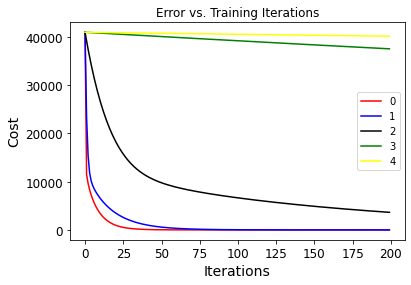

In [14]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.



#plt.figure(figsize=(20, 15))
#costs = []
#for i in range(1, 30):
#  myGradientDescentModel.alpha = 0.1
#  costs.append(myGradientDescentModel.fitUsingGradientDescent(X_train, y_train))
  #print(costs[i])
#  plt.plot(costs)
#print(costs)
#print(len(costs))
#print(costs[0])
#costs = []


# for each alpha:
  #create new model
  #train the model : cost = myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
  #plt.plot(cost)
print("initial:", cost)
list_alpha = [0.2, 0.1, 0.01, 0.0001, 0.000023]
#plt.legend(loc="upper right")
arr = []
for i in list_alpha:
  myGradientDescentModel = MyLinearRegression()
  myGradientDescentModel.alpha = [i]
  print(myGradientDescentModel.alpha)
  cost = myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
  #print(cost)
  arr.append(cost)
print(arr)
color_list = ['red', 'blue', 'black', 'green', 'yellow']
for j in range(0,5):
  plt.plot(arr[j], color=color_list[j], label=j)
#plt.plot(arr[1], color='blue', label='0.05')
#plt.plot(arr[2], color='blue', label='line two')
plt.legend()

plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations')  
plt.show()

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [15]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

37283419.823904134

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS 

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [16]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train,y_train)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("mySGDModel:", mySGDModel_rmse)

#myGradientDescentModel_rmse
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.alpha = [0.1]
myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
y_predict_gd = myGradientDescentModel.predict(X_test)
gd_rmse = np.sqrt(mean_squared_error(y_test, y_predict_gd))
print("myGDModel:",gd_rmse)

#myNormalEquationModel_rmse 
y_predict_normal = myNormalEquationModel.predict(X_test)
normal_rmse = np.sqrt(mean_squared_error(y_test, y_predict_normal))
print("myNormalEqModel:",normal_rmse)

mySGDModel: 5797.717659294291
myGDModel: 5796.31205250389
myNormalEqModel: 5793.723447883048


- - -
## Task 6. PRESENT YOUR SOLUTION 

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

# Your paragraph goes here for this section
My solution to this project is doing the coding part step by step by involving multiple print statement which in the end will direct me to the final answer.
One thing I learn so far is about gradient descent coding, I learned that a smaller learning rate would help us find the cost sooner than a larger learning rate. One of hte insight moving for improve the solution is to use a more smaller learning rate.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!